<a href="https://colab.research.google.com/github/Roan-k/Roan-k/blob/main/Image_clf_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Keras Simpsons Characters Classifier**

The goal of this project is training a nn that is able to classify the different characters of the Simpsons tv shows. The content of this project is as follows:

1. Importing libraries;
2. Downloading and cleaning data;
3. Simple CNN;
4. CNN with data augmentation and regularization;
5. Using VGG16 to classify;
6. Finetuning VGG16 final layers.

Source:https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset

**1. Importing libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shutil
import os

from PIL import Image
from pathlib import Path
from google.colab import files

import tensorflow as tf
import keras
from keras import layers
from keras import utils

**2. Downloading and cleaning data**

I download the dataset directly from Kaggle and unzipping it in a new folder

In [ ]:
! pip install -q kaggle

In [ ]:
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'alexattia/the-simpsons-characters-dataset'

 99% 1.07G/1.08G [00:08<00:00, 169MB/s]
100% 1.08G/1.08G [00:08<00:00, 130MB/s]


In [ ]:
! mkdir simpsons_data
! unzip the-simpsons-characters-dataset.zip -d simpsons_data

Streaminguitvoer ingekort tot de laatste 5000 regels.
  inflating: simpsons_data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1271.jpg  
  inflating: simpsons_data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1272.jpg  
  inflating: simpsons_data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1273.jpg  
  inflating: simpsons_data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1274.jpg  
  inflating: simpsons_data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1275.jpg  
  inflating: simpsons_data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1276.jpg  
  inflating: simpsons_data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1277.jpg  
  inflating: simpsons_data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1278.jpg  
  inflating: simpsons_data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1279.jpg  
  inflating: simpsons_data/simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1280.jpg  
  inflating: simpsons_data/simpsons_dataset/simpsons_dataset/moe_s

I delete a folder that I am not going to need. Then I also select 20 characters (out of 42) that I will be using for this project. Using only half of the characters reduces the training time; I don't want to spent too much time waiting on training.

In [ ]:
shutil.rmtree('simpsons_data/simpsons_dataset/simpsons_dataset/') #deletes a directory and all its contents.

In [ ]:
characters = ['abraham_grampa_simpson','apu_nahasapeemapetilon','barney_gumble','bart_simpson','carl_carlson','charles_montgomery_burns','chief_wiggum',
              'groundskeeper_willie','homer_simpson','krusty_the_clown','lenny_leonard','lisa_simpson','maggie_simpson','marge_simpson',
              'milhouse_van_houten','moe_szyslak','ned_flanders','nelson_muntz','principal_skinner','sideshow_bob']
print(len(characters))

20


In [ ]:
un_chars = list(os.walk('./simpsons_data/simpsons_dataset'))[0][1]

In [ ]:
del_chars = [char for char in un_chars if char not in characters]

In [ ]:
for char in del_chars:
  shutil.rmtree(f'simpsons_data/simpsons_dataset/{char}/') #deletes a directory and all its contents.

Then I create seperate folders for train, validation, and test, sending a certain number of images to each folder.

In [ ]:
data_dir = Path('simpsons_data/simpsons_dataset')

# N images per character
train_size = 100
val_size = 20
test_size = 20

original_dir = 'simpsons_data/simpsons_dataset'

train_dir = 'small_dataset/train'
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

val_dir = 'small_dataset/val_dir'
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

test_dir = 'small_dataset/test_dir'
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Train
for char in characters:
  src_folder = Path(os.path.join(original_dir, char))
  dst_folder = f'{train_dir}/{char}'
  if not os.path.exists(dst_folder): # creating a folder with the character's name
    os.makedirs(dst_folder)
  for i,pic in enumerate(list(src_folder.rglob('*jpg'))[:train_size]): # selecting N images and moving them
    src = pic
    dst = os.path.join(dst_folder,f'{char}_{i}.jpg')
    shutil.move(src, dst)

# Val
for char in characters:
  src_folder = Path(os.path.join(original_dir, char))
  dst_folder = f'{val_dir}/{char}'
  if not os.path.exists(dst_folder):
    os.makedirs(dst_folder)
  for i,pic in enumerate(list(src_folder.rglob('*jpg'))[:val_size]):
    src = pic
    dst = os.path.join(dst_folder,f'{char}_{i}.jpg')
    shutil.move(src, dst)

# Test
for char in characters:
  src_folder = Path(os.path.join(original_dir, char))
  dst_folder = f'{test_dir}/{char}'
  if not os.path.exists(dst_folder):
    os.makedirs(dst_folder)
  for i,pic in enumerate(list(src_folder.rglob('*jpg'))[:test_size]):
    src = pic
    dst = os.path.join(dst_folder,f'{char}_{i}.jpg')
    shutil.move(src, dst)

Next I make dataloaders for the training. I use a validation_split as a way of testing the effects of different numbers of training images.

In [ ]:
batch_size = 32
img_height = 200
img_width = 200

train_ds = tf.keras.utils.image_dataset_from_directory(
  'small_dataset/train',
  validation_split=0.2,
  subset="training",
  seed=42,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'small_dataset/val_dir',
  subset="validation",
  seed=42,
  label_mode = 'categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 1998 files belonging to 20 classes.
Using 1599 files for training.
Found 366 files belonging to 20 classes.
Using 73 files for validation.
['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'groundskeeper_willie', 'homer_simpson', 'krusty_the_clown', 'lenny_leonard', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'principal_skinner', 'sideshow_bob']


In [ ]:
print(len(class_names))

20


Plotting a few images to check them and to see if the labels are correct.

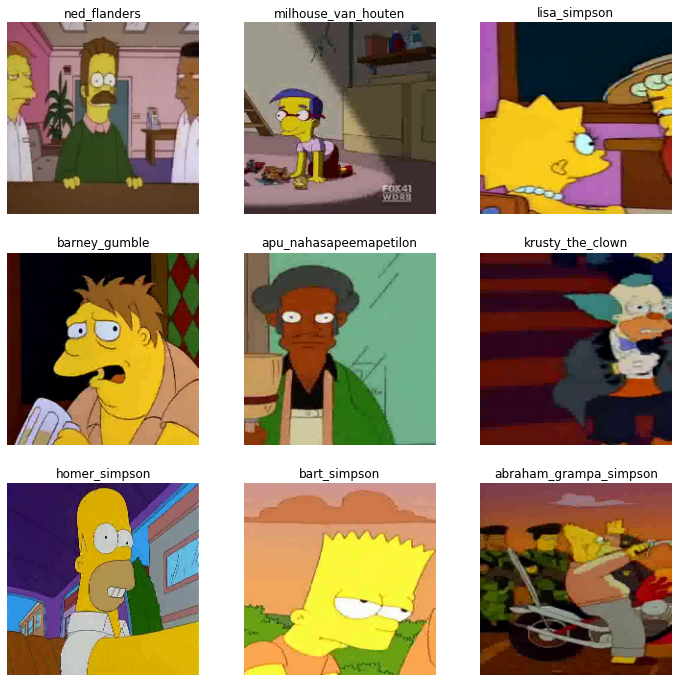

In [ ]:
plt.figure(figsize = (12,12))
for im, label in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3, i + 1)
    plt.imshow(im[i].numpy().astype('uint8'))
    name = class_names[np.argmax(label[i])] # because the labels are hot-encoded, I have to look them up using indeces
    plt.title(name)
    plt.axis("off")

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

**3. Simple CNN**

I write a relatively simple CNN with 4 convolutional blocks, each containing pooling layers. Convolutional layers are very effective for images as they reduce the number of trainable parameters and I use pooling so the nn is less sensitive to changes in characters' image locations.

In [ ]:
keras.backend.clear_session()

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

model = keras.models.Sequential([
        normalization_layer,                       
        layers.Conv2D(filters = 64, kernel_size = 3, strides = (1,1), input_shape = (200,200,3), activation = 'relu', padding = 'same'),
        layers.MaxPooling2D((2,2)),
    
        layers.Conv2D(128, 3, (1,1), input_shape = (99,99,64), activation = 'relu', padding = 'same'),
        layers.MaxPooling2D((2,2)),
    
        layers.Conv2D(256, 3, (1,1), input_shape = (48,48,128), activation = 'relu', padding = 'same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(256, 3, (1,1), input_shape = (23,23,256), activation = 'relu', padding = 'same'),
        layers.MaxPooling2D((2,2)),
    
        layers.Flatten(),
        layers.Dense(20, activation = 'relu'),

        layers.Dense(20,activation = 'softmax')
        ])

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [ ]:
model.build((1,200,200,3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (1, 200, 200, 3)          0         
                                                                 
 conv2d (Conv2D)             (1, 198, 198, 64)         1792      
                                                                 
 max_pooling2d (MaxPooling2D  (1, 99, 99, 64)          0         
 )                                                               
                                                                 
 re_lu (ReLU)                (1, 99, 99, 64)           0         
                                                                 
 conv2d_1 (Conv2D)           (1, 97, 97, 128)          73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (1, 48, 48, 128)         0         
 2D)                                                    

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = 'accuracy')

In [ ]:
history = model.fit(train_ds, validation_data = val_ds,  epochs = 30, verbose = True)

Epoch 1/30
50/50 [==============================] - 6s 109ms/step - loss: 3.0022 - accuracy: 0.0463 - val_loss: 2.9964 - val_accuracy: 0.0274
Epoch 2/30
50/50 [==============================] - 6s 106ms/step - loss: 2.9781 - accuracy: 0.0607 - val_loss: 2.9530 - val_accuracy: 0.0137
Epoch 3/30
50/50 [==============================] - 6s 107ms/step - loss: 2.8226 - accuracy: 0.1507 - val_loss: 2.8274 - val_accuracy: 0.1918
Epoch 4/30
50/50 [==============================] - 6s 106ms/step - loss: 2.6644 - accuracy: 0.2020 - val_loss: 2.7268 - val_accuracy: 0.1781
Epoch 5/30
50/50 [==============================] - 6s 107ms/step - loss: 2.4862 - accuracy: 0.2458 - val_loss: 2.6561 - val_accuracy: 0.1918
Epoch 6/30
50/50 [==============================] - 6s 106ms/step - loss: 2.2635 - accuracy: 0.3240 - val_loss: 2.5892 - val_accuracy: 0.2603
Epoch 7/30
50/50 [==============================] - 6s 115ms/step - loss: 1.9922 - accuracy: 0.3934 - val_loss: 2.6279 - val_accuracy: 0.2603
Epoch 

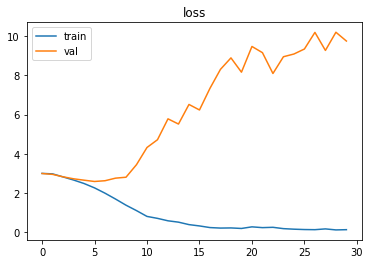

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label ='train')
plt.plot(val_loss, label = 'val')
plt.legend()
plt.title('loss')
plt.show()

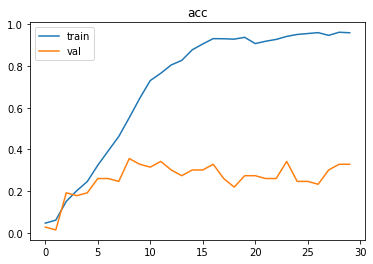

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(train_acc, label ='train')
plt.plot(val_acc, label = 'val')
plt.legend()
plt.title('acc')
plt.show()

There's a clear sign of overfitting on the data, as training accuracy reaches over 90% whereas validation accuracy gets stuck around 30%. This is expected, given the relatively small number of images per class.

To counter this, I'll apply data augmentation and regularization. This should help the model generalize better.

In [ ]:
# DATA AUGMENTATION

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

train_ds_aug = train_datagen.flow_from_directory(
        'small_dataset/train',
        target_size=(200, 200),
        batch_size=32,
        class_mode='categorical')

val_ds = test_datagen.flow_from_directory(
        'small_dataset/val_dir',
        target_size=(200, 200),
        batch_size=32,
        class_mode='categorical')

test_ds = test_datagen.flow_from_directory(
        'small_dataset/test_dir',
        target_size=(200, 200),
        batch_size=32,
        class_mode='categorical')

Found 1998 images belonging to 20 classes.
Found 366 images belonging to 20 classes.
Found 329 images belonging to 20 classes.


In [ ]:
keras.backend.clear_session()

model = keras.models.Sequential([                     
        layers.Conv2D(filters = 64, kernel_size = 3, strides = (1,1), input_shape = (200,200,3), padding = 'same'),
        layers.MaxPooling2D((2,2)),
        layers.ReLU(),
    
        layers.Conv2D(128, 3, (1,1), input_shape = (99,99,64), padding = 'same'),
        layers.MaxPooling2D((2,2)),
        layers.ReLU(),
    
        layers.Conv2D(256, 3, (1,1), input_shape = (48,48,128), padding = 'same'),
        layers.MaxPooling2D((2,2)),
        layers.ReLU(),

        layers.Conv2D(256, 3, (1,1), input_shape = (23,23,256), padding = 'same'),
        layers.MaxPooling2D((2,2)),
        layers.ReLU(),
        layers.Dropout(0.5),
    
        layers.Flatten(),
        layers.Dense(20, activation = 'relu'),

        layers.Dense(20,activation = 'softmax')
        ])

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = 'accuracy')
history = model.fit(train_ds_aug, validation_data = val_ds,  epochs = 40, verbose = True)

Epoch 1/40
63/63 [==============================] - 24s 368ms/step - loss: 2.9951 - accuracy: 0.0526 - val_loss: 3.0367 - val_accuracy: 0.0164
Epoch 2/40
63/63 [==============================] - 23s 367ms/step - loss: 2.9865 - accuracy: 0.0616 - val_loss: 2.9742 - val_accuracy: 0.0683
Epoch 3/40
63/63 [==============================] - 23s 364ms/step - loss: 2.9308 - accuracy: 0.0926 - val_loss: 2.8259 - val_accuracy: 0.1421
Epoch 4/40
63/63 [==============================] - 24s 375ms/step - loss: 2.8782 - accuracy: 0.1201 - val_loss: 2.7209 - val_accuracy: 0.1694
Epoch 5/40
63/63 [==============================] - 24s 383ms/step - loss: 2.7813 - accuracy: 0.1476 - val_loss: 2.5908 - val_accuracy: 0.1421
Epoch 6/40
63/63 [==============================] - 23s 366ms/step - loss: 2.6975 - accuracy: 0.1652 - val_loss: 2.5305 - val_accuracy: 0.1612
Epoch 7/40
63/63 [==============================] - 23s 363ms/step - loss: 2.6592 - accuracy: 0.1837 - val_loss: 2.4506 - val_accuracy: 0.1694

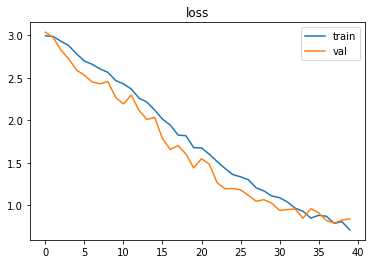

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label ='train')
plt.plot(val_loss, label = 'val')
plt.legend()
plt.title('loss')
plt.show()

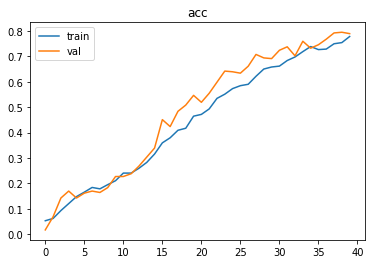

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(train_acc, label ='train')
plt.plot(val_acc, label = 'val')
plt.legend()
plt.title('acc')
plt.show()

There's a clear improvement compared to the first cnn. This time, the models is much better in generalizing to the validation data.

Next I try to use the VGG16 model to see if this pre-trained model can do (much) better. The VGG16 is trained on very different images, but still the convolutional layers could be very useful in extracting features.

In [ ]:
# TRANSFER LEARNING

keras.backend.clear_session()

input = tf.keras.layers.Input(shape=(200,200,3))

base = tf.keras.applications.VGG16(
        include_top = False,
        weights = 'imagenet',
        input_shape = (200,200,3)
)

for layer in base.layers:
	layer.trainable = False

x = base(input, training = False)

dense = keras.models.Sequential([
        layers.Flatten(),
        layers.Dropout(0.4),
        layers.Dense(270,activation = 'ReLU', kernel_regularizer=keras.regularizers.L2(l2=1e-2)), #, kernel_regularizer=keras.regularizers.L2(l2=1e-2)
        layers.Dropout(0.3),
        layers.Dense(100,activation = 'ReLU', kernel_regularizer=keras.regularizers.L2(l2=1e-3)), #, kernel_regularizer=keras.regularizers.L2(l2=1e-2)
        layers.Dropout(0.3),
        layers.Dense(20, activation = 'softmax')
        ])(x)

model = keras.Model(input, dense)

In [ ]:
# DATA LOADING AND PREPROCESSING

#def preprocess(images,labels):
  #return tf.keras.applications.mobilenet_v2.preprocess_input(images), labels

preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

data_prep = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function= preprocess)

train_ds_prep = data_prep.flow_from_directory(
        'small_dataset/train',
        batch_size=32,
        target_size=(200, 200),
        class_mode='categorical')

val_ds = data_prep.flow_from_directory(
        'small_dataset/val_dir',
        batch_size=32,
        target_size=(200, 200),
        class_mode='categorical')

test_ds = data_prep.flow_from_directory(
        'small_dataset/test_dir',
        batch_size=32,
        target_size=(200, 200),
        class_mode='categorical')

Found 1998 images belonging to 20 classes.
Found 366 images belonging to 20 classes.
Found 329 images belonging to 20 classes.


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = 'accuracy')
history = model.fit(train_ds_prep, validation_data = val_ds,  epochs = 40, verbose = True)

Epoch 1/40
63/63 [==============================] - 12s 175ms/step - loss: 5.8401 - accuracy: 0.0681 - val_loss: 4.3508 - val_accuracy: 0.1721
Epoch 2/40
63/63 [==============================] - 12s 192ms/step - loss: 3.9114 - accuracy: 0.1196 - val_loss: 3.4989 - val_accuracy: 0.2459
Epoch 3/40
63/63 [==============================] - 11s 175ms/step - loss: 3.2563 - accuracy: 0.2237 - val_loss: 2.9372 - val_accuracy: 0.3825
Epoch 4/40
63/63 [==============================] - 11s 175ms/step - loss: 2.8807 - accuracy: 0.3208 - val_loss: 2.7294 - val_accuracy: 0.4372
Epoch 5/40
63/63 [==============================] - 12s 186ms/step - loss: 2.7086 - accuracy: 0.3834 - val_loss: 2.7596 - val_accuracy: 0.3962
Epoch 6/40
63/63 [==============================] - 11s 171ms/step - loss: 2.5544 - accuracy: 0.4444 - val_loss: 2.5222 - val_accuracy: 0.4945
Epoch 7/40
63/63 [==============================] - 11s 170ms/step - loss: 2.4147 - accuracy: 0.4970 - val_loss: 2.4866 - val_accuracy: 0.5328

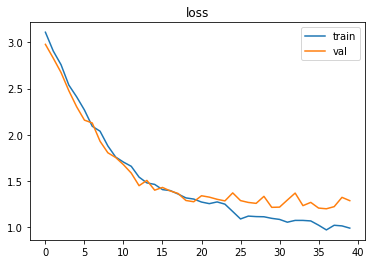

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label ='train')
plt.plot(val_loss, label = 'val')
plt.legend()
plt.title('loss')
plt.show()

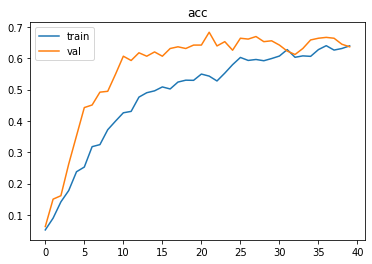

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(train_acc, label ='train')
plt.plot(val_acc, label = 'val')
plt.legend()
plt.title('acc')
plt.show()

In [ ]:
base.layers[-3:]

In [ ]:
# TRANSFER LEARNING

#keras.backend.clear_session()

input = tf.keras.layers.Input(shape=(200,200,3))

base = tf.keras.applications.VGG16(
        include_top = False,
        weights = 'imagenet',
        input_shape = (200,200,3)
)

for layer in base.layers:
	layer.trainable = False
for layer in base.layers[-2:]:
  layer.trainable = True

x = base(input, training = True)

dense = keras.models.Sequential([
        layers.Flatten(),
        layers.Dense(140,activation = 'ReLU',kernel_regularizer=keras.regularizers.L2(l2=1e-2)), #, kernel_regularizer=keras.regularizers.L2(l2=1e-2)
        layers.Dropout(0.3),
        layers.Dense(80,activation = 'ReLU'), #, kernel_regularizer=keras.regularizers.L2(l2=1e-2)
        layers.Dropout(0.2),
        layers.Dense(20, activation = 'softmax')
        ])(x)

model = keras.Model(input, dense)

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics = 'accuracy')
history = model.fit(train_ds_prep, validation_data = val_ds,  epochs = 10, verbose = True)

Epoch 1/10
63/63 [==============================] - 12s 175ms/step - loss: 5.7749 - accuracy: 0.0576 - val_loss: 5.6893 - val_accuracy: 0.0683
Epoch 2/10
63/63 [==============================] - 11s 171ms/step - loss: 5.6673 - accuracy: 0.0621 - val_loss: 5.6059 - val_accuracy: 0.0710
Epoch 3/10
63/63 [==============================] - 11s 171ms/step - loss: 5.5635 - accuracy: 0.0856 - val_loss: 5.4834 - val_accuracy: 0.1066
Epoch 4/10
63/63 [==============================] - 11s 172ms/step - loss: 5.3974 - accuracy: 0.1261 - val_loss: 5.2746 - val_accuracy: 0.2049
Epoch 5/10
63/63 [==============================] - 11s 172ms/step - loss: 5.1309 - accuracy: 0.2002 - val_loss: 4.8961 - val_accuracy: 0.3661
Epoch 6/10
63/63 [==============================] - 11s 179ms/step - loss: 4.7239 - accuracy: 0.3168 - val_loss: 4.4840 - val_accuracy: 0.4563
Epoch 7/10
63/63 [==============================] - 11s 173ms/step - loss: 4.2852 - accuracy: 0.4484 - val_loss: 4.0884 - val_accuracy: 0.5628

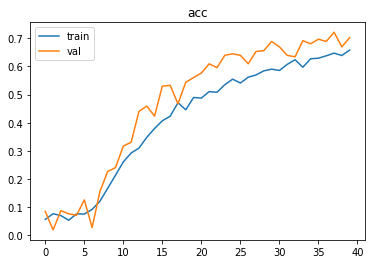

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(train_acc, label ='train')
plt.plot(val_acc, label = 'val')
plt.legend()
plt.title('acc')
plt.show()